# Image Analysis : Facial Analyis + Emotion

Use the face finder to to find and image to apply 

- TODO : switch to this : https://gist.github.com/ddebrunner/21db521909accd2ec364861964e18ae3
- TODO : use the : __enter__ construct

## AKA - WikiRecentPhase5
### Use learning models from IBM's [Model Asset Exchange](https://developer.ibm.com/exchanges/models/)

[Jump Table](#jumpTable)

Use the  [IBM emotion classifier](https://developer.ibm.com/exchanges/models/all/max-facial-emotion-classifier/) to analyise images that are being added to wikiepedia. We've dervived the links to images in the last phase now score
them, possibly humans photo and classify the emotional state. 

Built on previous pages, the further back you go the more detail  
 - WikiRecentPhase0 - connect to live wiki updates
 - WikiRecentPhase1 - filter out bot processing
 - WikiRecentPhase2 - derive the current: editor, title, language
 - WikiRecentPhase3 - extract image, if it exists
 - WikiRecentPhase4 - find all faces in image
 - WikiRecentPhase5 - emotional analysis on faces
 


In [1]:
# Install components
!pip install sseclient
!pip install --user --upgrade streamsx

You are using pip version 18.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: streamsx in /Users/siegenth/.local/lib/python3.5/site-packages (1.12.10)
You are using pip version 18.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Setup 
import pandas as pd
import pandas

from IPython.core.debugger import set_trace
from IPython.display import display, clear_output

import io
from statistics import mean
from collections import deque
from collections import Counter
from collections import OrderedDict

from urllib.parse import urlparse

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox, Layout
from matplotlib.pyplot import imshow
from PIL import Image, ImageTk

from bs4 import BeautifulSoup
from urllib.parse import urlparse
import numpy as np

%matplotlib inline

from sseclient import SSEClient as EventSource

from ipywidgets import Button, HBox, VBox, Layout

from  functools import lru_cache
import requests

from PIL import Image
from io import BytesIO
import copy
import base64

from streamsx.topology.topology import *
import streamsx.rest as rest
from streamsx.topology import context

## Support functions for Jupyter

In [3]:
def catchInterrupt(func):
    """decorator : when interupt occurs the display is lost if you don't catch it
       TODO * <view>.stop_data_fetch()  # stop
       
    """
    def catch_interrupt(*args, **kwargs):
        try: 
            func(*args, **kwargs)
        except (KeyboardInterrupt): pass
    return catch_interrupt

#
# Support for locating/rendering views.
def display_view_stop(eventView, period=2):
    """Wrapper for streamsx.rest_primitives.View.display() to have button. """
    button =  widgets.Button(description="Stop Updating")
    display(button)
    eventView.display(period=period) 
    def on_button_clicked(b):
        eventView.stop_data_fetch()
        b.description = "Stopped"
    button.on_click(on_button_clicked)

def view_events(views):
    """
    Build interface to display a list of views and 
    display view when selected from list.
     
    """
    view_names = [view.name for view in views]
    nameView = dict(zip(view_names, views))    
    select = widgets.RadioButtons(
        options = view_names,
        value = None,
        description = 'Select view to display',
        disabled = False
    )
    def on_change(b):
        if (b['name'] == 'label'):
            clear_output(wait=True)
            [view.stop_data_fetch() for view in views ]
            display(select)
            display_view_stop(nameView[b['new']], period=2)
    select.observe(on_change)
    display(select)

def find_job(instance, job_name=None):
    """locate job within instance"""
    for job in instance.get_jobs():    
        if job.applicationName.split("::")[-1] == job_name:
            return job
    else:
        return None

def display_views(instance, job_name):
    "Locate/promote and display all views of a job"
    job = find_job(instance, job_name=job_name)
    if job is None:
        print("Failed to locate job")
    else:
        views = job.get_views()
        view_events(views)

def list_jobs(_instance=None, cancel=False):
    """
    Interactive selection of jobs to cancel.
    
    Prompts with SelectMultiple widget, if thier are no jobs, your presente with a blank list.
    
    """
    active_jobs = { "{}:{}".format(job.name, job.health):job for job in _instance.get_jobs()}

    selectMultiple_jobs = widgets.SelectMultiple(
        options=active_jobs.keys(),
        value=[],
        rows=len(active_jobs),
        description = "Cancel jobs(s)" if cancel else "Active job(s):",
        layout=Layout(width='60%')
    )
    cancel_jobs = widgets.ToggleButton(
        value=False,
        description='Cancel',
        disabled=False,
        button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Delete selected jobs',
        icon="stop"
    )
    def on_value_change(change):
        for job in selectMultiple_jobs.value:
            print("canceling job:", job, active_jobs[job].cancel())
        cancel_jobs.disabled = True
        selectMultiple_jobs.disabled = True

    cancel_jobs.observe(on_value_change, names='value')
    if cancel:
        return HBox([selectMultiple_jobs, cancel_jobs])
    else:
        return HBox([selectMultiple_jobs])
    
def render_image(image_url=None, output_region=None):
    """Write the image into a output region.
    
    Args::
        url: image
        output_region: output region
        
    .. note:: The creation of the output 'stage', if this is not done the image is rendered in the page and
        the output region. 
        
    """
    
    try:
        response = requests.get(image_url)
        stage = widgets.Output(layout={'border': '1px solid green'})
    except:
        print("Error on request : ", image_url)
    else:
        if response.status_code == 200:
            with output_region:
                stage.append_display_data(widgets.Image(
                    value=response.content,
                    #format='jpg',
                    width=300,
                    height=400,
                ))
            output_region.clear_output(wait=True) 

## Connect to the service: Cloud/ICP4D

TODO - collapse these three cells one

In [4]:
def get_instance_cfg():
    """Use to setup the instance and cfg variable to access your Streams instance.
    
    ..note::The notebook is designed work with Cloud and ICP4D. 
            If using ICP4D following the instructions in cell '1. Setup' cell 
            would have configure you environment for ICP4D. 
            Using Streams on the Cloud involves setting 
            up the config file as described in the markdown file. 
    Returns:
        instance : Access to Streams instance, used for submitting and rendering views.
        cfg: used in conjunction with ICP4D
     
    """
    try:
        from icpd_core import icpd_util
        cfg = icpd_util.get_service_instance_details(name='sample-icp1')
        cfg[context.ConfigParams.SSL_VERIFY] = False
        instance = rest.Instance.of_service(cfg)
        print("Within ICP4D")
        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    except ImportError:
        import common
        cfg = None
        print("Outside ICP4D")
        import credential   # remove @ ICP4D
        import common
        # - link up to first cell (can you do a test and execute)
        sc = rest.StreamingAnalyticsConnection(service_name='Streaming3Turbine', vcap_services={'streaming-analytics':[{'name':'Streaming3Turbine','credentials':credential.streaming3Turbine}]})
        instance = sc.get_instances()[0]
    return instance, cfg

instance, cfg = get_instance_cfg()

Outside ICP4D


## List jobs and cancel....

This page will submit a job named 'WikiPhase3'. If it's running you'll want to cancel it before submitting a new version. If it is running, no need to cancel/submit you can just procede to the Viewing data section.


In [5]:
list_jobs(instance, cancel=True)

HBox(children=(SelectMultiple(description='Cancel jobs(s)', layout=Layout(width='60%'), options=(), rows=0, value=()), ToggleButton(value=False, button_style='warning', description='Cancel', icon='stop', tooltip='Delete selected jobs')))

### [Jump Table](#jumpTable)

<a id='accessFoundation'></a>
## Support functions that are executed within Streams

Details of these functions can be found in previous notesbooks of this suite.


In [6]:
import csv
class wiki_lang():
    """
    Augment the tuple to include language wiki event.
    
    Mapping is loaded at build time and utilized at runtime.
    """

    def __init__(self, fname="wikimap.csv"):
        self.wiki_map = dict()
        with open(fname, mode='r') as csv_file:
            csv_reader = csv.DictReader(csv_file)
            for row in csv_reader:
                self.wiki_map[row['dbname']] = row

    def __call__(self, tuple):
        """using 'wiki' field to look pages code, langauge and native
        Args:
            tuple: tuple (dict) with a 'wiki' fields
        Returns:'
            input tuple with  'code', 'language, 'native' fields added to the input tuple.
        """
        if tuple['wiki'] in self.wiki_map:
            key = tuple['wiki']
            tuple['code'] = self.wiki_map[key]['code']
            tuple['language'] = self.wiki_map[key]['in_english']
            tuple['native'] = self.wiki_map[key]['name_language']
        else:
            tuple['code'] = tuple['language'] = tuple['native'] = None
        return tuple



def get_events():
    """fetch recent changes from wikievents site using SSE"""
    for change in EventSource('https://stream.wikimedia.org/v2/stream/recentchange'):
        if len(change.data):
            try:
                obj = json.loads(change.data)
            except json.JSONDecodeError as err:
                print("JSON l1 error:", err, "Invalid JSON:", change.data)
            except json.decoder.JSONDecodeError as err:
                print("JSON l2 error:", err, "Invalid JSON:", change.data)
            else:
                yield(obj)


class sum_aggregation():
    def __init__(self, sum_map={'new_len':'newSum','old_len':'oldSum','delta_len':'deltaSum' }):
        """
        Summation of column(s) over a window's tuples. 
        Args::
            sum_map :  specfify tuple columns to be summed and the result field. 
            tuples : at run time, list of tuples will flow in. Sum each fields
        """
        self.sum_map = sum_map
    def __call__(self, tuples)->dict: 
        """
        Args:
            tuples : list of tuples constituting a window, over all the tuples sum using the sum_map key/value 
                     to specify the input and result field.
        Returns:
            dictionary of fields summations over tuples
            
        """
        summaries = dict()
        for summary_field,result_field in self.sum_map.items():
            summation = sum([ele[summary_field] for ele in tuples])
            summaries.update({result_field : summation})
        return(summaries)

import collections
class tally_fields(object):
    def __init__(self, top_count=3, fields=['user', 'wiki', 'title']):
        """
        Tally fields of a list of tuples.
        Args::
            fields :  fields of tuples that are to be tallied
        """
        self.fields = fields
        self.top_count = top_count
    def __call__(self, tuples)->dict:
        """
        Args::
            tuples : list of tuples tallying to perform. 
        return::
            dict of tallies
        """
        tallies = dict()
        for field in self.fields:
            stage = [tuple[field] for tuple in tuples if tuple[field] is not None]
            tallies[field] = collections.Counter(stage).most_common(self.top_count)
        return tallies

#@lru_cache(maxsize=None)
def shred_item_image(url):
    """Shred the item page, seeking image. 
    
    Discover if referencing image by shredding referening url. If it is, dig deeper 
    and extract the 'src' link. 
    
    Locate the image within the page, locate <a class='image' src=**url** ,..>
    
    This traverses two files, pulls the thumbnail ref and follows to fullsize.
    
    Args:
        url: item page to analyse
    
    Returns: 
        If image found [{name,title,org_url},...]
    
    .. warning:: this fetches from wikipedia, requesting too frequenty is bad manners. Uses the lru_cache()
    so it minimises the requests.
    
    This can pick up multiple titles, on a page that is extract, dropping to only one. 
    """
    img_urls = list()
    try:
        rThumb = requests.get(url = url)
        #print(r.content)
        soupThumb = BeautifulSoup(rThumb.content, "html.parser")
        divThumb = soupThumb.find("div", class_="thumb")
        if divThumb is None:
            print("No thumb found", url  )
            return img_urls
        thumbA = divThumb.find("a", class_="image")
        thumbHref = thumbA.attrs['href']

        rFullImage = requests.get(url=thumbHref)
        soupFull = BeautifulSoup(rFullImage.content, "html.parser")
    except Exception as e:
        print("Error request.get, url: {} except:{}".format(url, str(e)))
    else:
        divFull = soupFull.find("div", class_="fullImageLink", id="file")
        if (divFull is not None):
            fullA = divFull.find("a")
            img_urls.append({"title":soupThumb.title.getText(),"img": fullA.attrs['href'],"org_url":url})
    finally:
        return img_urls

#@lru_cache(maxsize=None)
def shred_jpg_image(url):
    """Shed the jpg page, seeking image, the reference begins with 'Fred:' and 
    ends with '.jpg'.
    
    Discover if referencing image by shredding referening url. If it is, dig deeper 
    and extract the 'src' link. 
    
    Locate the image within the page, 
            locate : <div class='fullImageLinks'..>
                         <a href="..url to image" ...>.</a>
                         :
                     </div>  
    Args:
        url: item page to analyse
    
    Returns: 
        If image found [{name,title,org_url='requesting url'},...]
    
    .. warning:: this fetches from wikipedia, requesting too frequenty is bad manners. Uses the lru_cache()
    so it minimises the requests.
    
    """
    img_urls = list()
    try:
        r = requests.get(url = url)
        soup = BeautifulSoup(r.content, "html.parser")
    except Exception as e:
        print("Error request.get, url: {} except:{}".format(url, str(e)))
    else:
        div = soup.find("div", class_="fullImageLink")
        if (div is not None):
            imgA = div.find("a")
            img_urls.append({"title":soup.title.getText(),"img":"https:" + imgA.attrs['href'],"org_url":url})
        else: 
            print("failed to find div for",url)
    finally:
        return img_urls

class soup_image_extract():
    """If the the field_name has a potential a image we
    
    Return: 
        None : field did not have potenital for an image.
        [] : had potential but no url found. 
        [{title,img,href}]
    """
    def __init__(self, field_name="title", url_base="https://www.wikidata.org/wiki/"):
        self.url_base = url_base
        self.field_name = field_name
    
    def __call__(self, _tuple):
        title = _tuple[self.field_name]
        img_desc = None 
        if (title[0] == "Q"):
            lnk = self.url_base + title
            img_desc = shred_item_image(lnk)
        elif title.startswith("File:") and (title.endswith('.JPG') or title.endswith('.jpg')):
            lnk = self.url_base + title.replace(' ','_')
            img_desc = shred_jpg_image(lnk)
        _tuple['img_desc'] = img_desc
        return _tuple

class soup_image():
    """If the the field_name has a potential for a image we
    
    Return: 
        None : field did not have potenital for an image.
        [] : had potential but no url found. 
        [{title,img,href}]
    """


    def __init__(self, field_name="title", url_base="https://www.wikidata.org/wiki/"):
        self.url_base = url_base
        self.field_name = field_name
        self.cache_item = None
        self.cache_jpg = None
    
    def __call__(self, _tuple):
        if self.cache_item is None:
            self.cache_item = cache_url_process(shred_item_image)
            self.cache_jpg = cache_url_process(shred_jpg_image)
        title = _tuple[self.field_name]
        img_desc = None 
        if (title[0] == "Q"):
            lnk = self.url_base + title
            img_desc = self.cache_item.cache_process(lnk)
            print("cache_item", self.cache_item.stats())

        elif title.startswith("File:") and (title.endswith('.JPG') or title.endswith('.jpg')):
            lnk = self.url_base + title.replace(' ','_')
            img_desc = self.cache_jpg.cache_process(lnk)
            print("cache_jpg", self.cache_jpg.stats())

            #print("cache_jpg", self.cache_jpg.stats())
            
        _tuple['img_desc'] = img_desc
        return _tuple

## Support of streams processing
class cache_url_process():
    def __init__(self, process_url, cache_max=200):
        """I would use @lru_cache() but I ran into two problems. 
           - when I got to the server it could not find the function. 
           - get a stack overflow when building the topology. 
        Args::
            process_url: a function that process's the request, when not cached.
            Function will accept a URL and retrn  dict.
        Return::
            result from process_url that may be a cached value.
            
        """
        self.urls = OrderedDict()
        self.hits = 0
        self.attempts = 0
        self.process = process_url
        self.cache_max = cache_max
    def cache_process(self, url):
        self.attempts += 1
        if url in self.urls:
            self.hits += 1
            stage = self.urls[url]
            del self.urls[url]  # move to begining of que
            self.urls[url] = stage
            n = len(self.urls) - self.cache_max 
            [self.urls.popitem(last=False) for idx in range(n if n > 0 else 0)]
            return stage
        stage = self.process(url)
        self.urls[url] = stage
        return stage
    def stats(self):
        return dict({"attempts":self.attempts,"hits":self.hits,"len":len(self.urls)})
 

<a id='facialFunctionality'></a>
## Facial Image Extraction + Emotion Analysis
[Jump Table](#jumpTable)

Using [IBM Facial Recognizer](https://developer.ibm.com/exchanges/models/all/max-facial-recognizer/)


In [7]:
tmpBufIoOut = None

def facial_fetch(imgurl):
    """ Our friends: "https://developer.ibm.com/exchanges/models/all/max-facial-emotion-classifier/"

    ..note: 
        This utilizing a function put up the by our friends, $$ == 0.
        It can stop working at anytime. 
    """
    predict_url='http://max-facial-recognizer.max.us-south.containers.appdomain.cloud/model/predict'
    parsed = urlparse(imgurl)   
    filename = parsed.path.split('/')[-1]
    if (filename.lower().endswith('.svg')):
        print("Cannot process svg:", imgurl)
        return list(), None
    if (filename.lower().endswith('.tif')):
        print("Cannot process tif:", imgurl)
        return list(), None
    try:
        page = requests.get(imgurl)
    except Exception as e:
        print("Image fetch exception:", e)
        return None, None
    bufIoOut = io.BytesIO(page.content)
    files = {'image': (filename, bufIoOut, "image/jpeg")}
    try: 
        r = requests.post(predict_url, files=files)
    except Exception as e:
        print("Analysis service exception", e)
        return None, None
    if (r.status_code != 200):
        print("Analysis failure:",r.status_code, r.json())
        return None, None
    analysis = r.json()
    return analysis, bufIoOut

def facial_locate(imgurl):
    analysis,bufIoOut = facial_fetch(imgurl)
    if bufIoOut is None:
        return None
    if (analysis['predictions']) == 0:
        print("No predictions found for", imgurl)
        return None
    return({'bin_image':bufIoOut, 'faces':analysis})

def crop_percent(img_dim, box_extent):
    """get the % of image the cropped image is"""
    img_size = img_dim[0] * img_dim[1]
    box_size = abs((int(box_extent[0]) - int(box_extent[2])) * (int(box_extent[1])- int(box_extent[3])))
    percent = ((box_size/img_size) * 100)
    return(percent)


def image_cropper(bin_image, faces):
    """Crop out the faces from a URL.
    Args:
        url : image images
        faces : list of {region,predictions} that that should be cropped
    Return:
        dict with 'annotated_image' and 'crops'
        'crops' is list of dicts with 
            {image:face image, 
             probability:chances it's a face, 
             image_percent:found reqion % of of the image, 
             detection_box:region of the original image that the image was extacted from}
         'crops' empty - nothing found, no faces found
    """
    crops = list()
    for face in faces['predictions']: 
        i = Image.open(bin_image)
        percent = crop_percent( i.size, face['detection_box'])
        img = i.crop(face['detection_box'])
        crops.append({'image':img, 'probability':face['probability'],'detection_box':face['detection_box'],'image_percent':percent})
    return crops



In [8]:
class facial_image():
    """Extract all the faces from an image, for each found face generate a tuple with a face field. 
    Args:
        - field_name : name of field on input tuple with the image description dict
        - img_field : dictionary entry that has url of image
        

    Return: 
        None - No 'img_desc' field or no faces found 
        List of tuples composed of the input tuple with a new 'face' field
        face a dictionary: 
        - probability : probability that it's a face
        - percentage : % of the field_img that the detection_box occupies
        - detection_box : within the orginal image, coodinates of extracted image
        - bytes_PIL_b64 : cropped image in binary Base64 ascii
    ..notes: 
        1. the next operator in line should be the flat_map() that takes the list of tuples and converts 
        to a stream of tuples.
    ..code::
        '''
        ## Example of displaying encoded cropped image.
        from PIL import Image
        from io import BytesIO
        import copy
        
        calidUrlImage = "URL of valid Image to be analysized"
        minimal_tuple = {'img_desc':[{'img':validUrlImage}]}
        fi = facial_image()
        crops = fi.__call__(minimal_tuple)
        for crop in crops:
            cropImg = Image.open(io.BytesIO(base64.b64decode(crop['face']['bytes_PIL_b64'])))
            print("Image Size",cropImg.size)
            display(cropImg)
        '''
    """
    def __init__(self, field_name="img_desc", url_base="https://www.wikidata.org/wiki/", image_field='img'):
        self.url_base = url_base
        self.img_desc = field_name
        self.img_field = image_field
        self.cache_item = None
    
    def __call__(self, _tuple):

        if self.img_desc not in _tuple or len(_tuple[self.img_desc]) == 0:
            return None
        desc = _tuple[self.img_desc][0]
        if self.img_field not in desc:
            print("Missing 'img' field in 'img_desc'")
            return None
        processed = facial_locate(desc[self.img_field])
        if processed is None:
            return None

        crops = image_cropper(processed['bin_image'], processed['faces'])
        tuples = list()
        for crop in crops:
            augmented_tuple = copy.copy(_tuple)
            with io.BytesIO() as output:
                crop['image'].save(output, format="JPEG")
                contents = output.getvalue() 
            crop['bytes_PIL_b64'] = base64.b64encode(contents).decode('ascii')
            del crop['image']
            augmented_tuple['face'] = crop
            tuples.append(augmented_tuple)
        return tuples 

Image Size (115, 151)


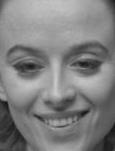

Image Size (125, 159)


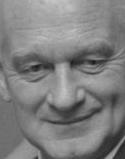

In [9]:
# ## Simulate a test tuple: facial_image
validUrlImage = "https://upload.wikimedia.org/wikipedia/commons/5/52/Bundesarchiv_B_145_Bild-F023358-0012%2C_Empfang_in_der_Landesvertretung_Bayern%2C_Hallstein.jpg"
minimal_tuple = {'img_desc':[{'img':validUrlImage}]}
fi = facial_image()
crops = fi.__call__(minimal_tuple)
for crop in crops:
    cropImg = Image.open(io.BytesIO(base64.b64decode(crop['face']['bytes_PIL_b64'])))
    #cropImg = Image.open(io.BytesIO(res[0]['face']['bytes_PIL']))
    print("Image Size",cropImg.size)
    display(cropImg)

<a id='analysisFunctionality'></a>
## Facial Analysis Functionality
[Jump Table](#jumpTable)

Using the  [IBM emotion classifier](https://developer.ibm.com/exchanges/models/all/max-facial-emotion-classifier/) to analyise images that are being added to wikiepedia.

In [10]:
def emotion_crop(bufIoOut, imgurl):
    """ Our friends: "https://developer.ibm.com/exchanges/models/all/max-facial-emotion-classifier/"
    
    Analyse an image using the service "http://max-facial-emotion-classifier.max.us-south.containers.appdomain.cloud/".
    
    Send binary image to analysis 
    
    The processing nodes not necessarily return a prediction, could be an indication that it's not a predictable image.
    
    Args:
        imgurl: the original source image that the cropped region came from
        buiIoOut : the binary cropped image to be analysized

    Returns:
        None - error encountered
        [] : executed, no prediction.
        [{anger,contempt,disgust,happiness,neutral,sadness,surpise}]   
    ..note: 
        This utilizing a function put up the by our friends, $$ == 0.
        It can stop working at anytime. 
    """
    predict_url='http://max-facial-emotion-classifier.max.us-south.containers.appdomain.cloud/model/predict'
    parsed = urlparse(imgurl)   
    filename = parsed.path.split('/')[-1]

    files = {'image': (filename, bufIoOut, "image/jpeg")}
    try: 
        r = requests.post(predict_url, files=files)
    except Exception as e:
        print("Analysis service exception", e)
        return None
    if (r.status_code != 200):
        print("Analysis failure:",r.status_code, r.json())
        return None
    analysis = r.json()
    if len(analysis['predictions']) == 0:
        return list()
    emotions = analysis['predictions'][0]['emotion_predictions']
    return [{emot['label']:float("{0:.2f}".format(emot['probability'])) for emot in emotions}]


In [11]:
class emotion_image():
    """If there is an img entry, attempt to analyize
    Args:
        field_name : name of field on input tuple with the image description dict
        img_field: dictionary entry that has url of image
    
    Return: 
        None - No 'img_desc' field or no entries in the field
        Add a emotion to the tuple. 
            Empty [] if nothing in img_desc or no emotion could be derived
            None : field did not have potenital for an image.
        [] : had potential but no url found. 
        [{title,img,href}]
    """
    def __init__(self):
        pass
    
    def __call__(self, _tuple):
        bufIoOut_decode_image = io.BytesIO(base64.b64decode(_tuple['face']['bytes_PIL_b64']))
        url = _tuple['img_desc'][0]['img']
        emotion = emotion_crop(bufIoOut_decode_image, url)
        _tuple['emotion'] = emotion
        return(_tuple)

Image Size (115, 151)


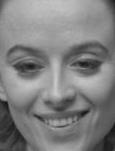

[{'contempt': 0.0, 'anger': 0.0, 'fear': 0.0, 'neutral': 0.0, 'happiness': 1.0, 'disgust': 0.0, 'surprise': 0.0, 'sadness': 0.0}]
Image Size (125, 159)


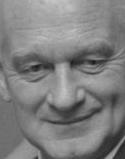

[{'contempt': 0.0, 'anger': 0.0, 'fear': 0.0, 'neutral': 0.0, 'happiness': 1.0, 'disgust': 0.0, 'surprise': 0.0, 'sadness': 0.0}]


In [12]:
## Simlate a test tuple: facial_image + emotion operators. 
validUrlImage = "https://upload.wikimedia.org/wikipedia/commons/5/52/Bundesarchiv_B_145_Bild-F023358-0012%2C_Empfang_in_der_Landesvertretung_Bayern%2C_Hallstein.jpg"
minimal_tuple = {'img_desc':[{'img':validUrlImage}]}
fi = facial_image()
crops = fi.__call__(minimal_tuple)
ei = emotion_image()
for crop in crops:
    cropImg = Image.open(io.BytesIO(base64.b64decode(crop['face']['bytes_PIL_b64'])))
    #cropImg = Image.open(io.BytesIO(res[0]['face']['bytes_PIL']))
    print("Image Size",cropImg.size)
    display(cropImg)
    print(ei.__call__(crop)['emotion'])

<a id='composeSubmit'></a>
## Compose, build and submit the Streams application.
The following Code cell composed the Streams application depicted here:
![stillPhase5.jpg](images/stillPhase5.jpg)

This is notebook is an extention of the previous, I'll only discuss processing beyond 'langAugment' for details regarding prior processing refer to previous [notebook](./imgAna_3.ipynb)s.

Facial Extraction

Face Emotion..

In [13]:
list_jobs(instance, cancel=True)

HBox(children=(SelectMultiple(description='Cancel jobs(s)', layout=Layout(width='60%'), options=(), rows=0, value=()), ToggleButton(value=False, button_style='warning', description='Cancel', icon='stop', tooltip='Delete selected jobs')))

In [14]:
## TODO If WikiPhase5 is running, cancel before submitting.


def WikiPhase5(jobName=None, wiki_lang_fname=None):
    """
    Compose topology. 
    -- wiki_lang : csv file mapping database name to langauge

    """
    topo = Topology(name=jobName)
    ### make sure we sseclient in Streams environment.
    topo.add_pip_package('sseclient')
    topo.add_pip_package('bs4')

    ## wiki events
    wiki_events = topo.source(get_events, name="wikiEvents")
    ## select events generated by humans
    human_filter = wiki_events.filter(lambda x: x['type']=='edit' and x['bot'] is False, name='humanFilter')
    # pare down the humans set of columns
    pared_human= human_filter.map(lambda x : {'timestamp':x['timestamp'],
                                              'new_len':x['length']['new'],
                                              'old_len':x['length']['old'], 
                                              'delta_len':x['length']['new'] - x['length']['old'],
                                              'wiki':x['wiki'],'user':x['user'],
                                              'title':x['title']}, 
                        name="paredHuman")
    pared_human.view(buffer_time=1.0, sample_size=200, name="paredEdits", description="Edits done by humans")

    ## Define window(count)& aggregate
    sum_win = pared_human.last(100).trigger(20)
    sum_aggregate = sum_win.aggregate(sum_aggregation(sum_map={'new_len':'newSum','old_len':'oldSum','delta_len':'deltaSum' }), name="sumAggregate")
    sum_aggregate.view(buffer_time=1.0, sample_size=200, name="aggEdits", description="Aggregations of human edits")

    ## Define window(count) & tally edits
    tally_win = pared_human.last(100).trigger(10)
    tally_top = tally_win.aggregate(tally_fields(fields=['user', 'title'], top_count=10), name="talliesTop")
    tally_top.view(buffer_time=1.0, sample_size=200, name="talliesCount", description="Top count tallies: user,titles")

    ## augment filterd/pared edits with language
    lang_augment = pared_human.map(wiki_lang(), name="langAugment")
    lang_augment.view(buffer_time=1.0, sample_size=200, name="langAugment", description="Language derived from wiki")

    ## Define window(time) & tally language
    time_lang_win = lang_augment.last(datetime.timedelta(minutes=2)).trigger(5)
    time_lang = time_lang_win.aggregate(tally_fields(fields=['language'], top_count=10), name="timeLang")
    time_lang.view(buffer_time=1.0, sample_size=200, name="talliesTime", description="Top timed tallies: language")

    ## attempt to extract image using beautifulsoup add img_desc[{}] field
    soup_image = lang_augment.map(soup_image_extract(field_name="title", url_base="https://www.wikidata.org/wiki/"),name="imgSoup")
    soup_active = soup_image.filter(lambda x: x['img_desc'] is not None and len(x['img_desc']) > 0, name="soupActive")
    soup_active.view(buffer_time=1.0, sample_size=200, name="soupActive", description="Image extracted via Bsoup")
    
    ## facial extraction  - 
    facial_images = soup_active.map(facial_image(field_name='img_desc'),name="facialImgs")
    face_image = facial_images.flat_map(name="faceImg")
    face_image.view(buffer_time=10.0, sample_size=20, name="faceImg", description="Face image analysis/extraction")

    ## emotion anaylsis on image - 
    face_emotion = face_image.map(emotion_image(), name="faceEmotion")
    face_emotion.view(buffer_time=10.0, sample_size=20, name="faceEmotion", description="Factial emotion analysis")
       
    return ({"topo":topo,"view":{ }})

## Submitting job : ICP or Cloud

In [15]:
if cfg is not None:
    resp = WikiPhase5(jobName="WikiPhase5")
    # Disable SSL certificate verification if necessary
    cfg[context.ConfigParams.SSL_VERIFY] = False

    submission_result = context.submit("DISTRIBUTED",
                                   resp['topo'], 
                                   config=cfg)
    # The submission_result object contains information about the running application, or job
    if submission_result.job:
        print("JobId: ", submission_result['id'] , "Name: ", submission_result['name'])
if cfg is None:
    import common
    resp = WikiPhase5(jobName="WikiPhase5")
    submitStatus = common.submitProcess(topology=resp['topo'],
                                        streamsService="Streaming3Turbine",
                                        buildType="DISTRIBUTED",
                                        serviceType="STREAMING_ANALYTIC",
                                        jobName="WikiPhase5",
                                        cancel=True)
    

Submission parameters:
  - serviceType:STREAMING_ANALYTIC
  - buildType:DISTRIBUTED
  - jobName:WikiPhase5
  - cancel:True
*** No jobs canceled


IntProgress(value=0, bar_style='info', description='Initializing', max=10, style=ProgressStyle(description_width='initial'))

<a id='runningActive'></a>
### Running / Active 
[Jump Table](#jumpTable)

In [16]:
list_jobs(instance, cancel=True)

HBox(children=(SelectMultiple(description='Cancel jobs(s)', layout=Layout(width='60%'), options=('ipythoninput1406fe87c09ce9::WikiPhase5_4:partiallyUnhealthy',), rows=1, value=()), ToggleButton(value=False, button_style='warning', description='Cancel', icon='stop', tooltip='Delete selected jobs')))

<a id='viewingData'></a>
## Viewing data 

The running application has number of views to see what what data is moving through the stream. The following 
cell will fetch the views' queue and display it's data when selected. 

|view name | description of data is the view | bot |
|---------|-------------|
|aggEdits  | summarised fields | False |
|langAugment | mapped augmented fields | False |
|paredEdits | seleted fields | False |
|talliesCount | last 100 messages tallied | False | 
|talliesTimes | 2 minute windowed | False |
|soupActive | extracted images links| False |
|faceImg | analyse image for faces and extract | False |
|faceEmotion | emotional analysis of facial images | False | 



You want to stop the the fetching the view data when done.

In [17]:
# View the data that is flowing.....
display_views(instance, "WikiPhase5")

RadioButtons(description='Select view to display', options=('aggEdits', 'faceEmotion', 'faceImg', 'langAugment', 'paredEdits', 'soupActive', 'talliesCount', 'talliesTime'), value=None)

<a id='jumpTable'></a>
### Jump Table..
- **[Running / Active](#runningActive)**
- [Access Foundation](#accessFoundation)@server
- [Compose Submit](#composeSubmit)@server
- [Language Distribution](#languageDistribution)
- [Soup Functionality](#soupFunctionality)@server
- [Image Extraction](#imageExtraction)  
- [Facial Image Extraction](#facialFunctionality)@server
- [Image Facial Location](#imageFacialAnalysis)
- [Analysis Functionaltiy](#analysisFunctionality)@server
- [Image Emotion Analysis](#imageEmotionAnalysis) : 
- 

![phase4_1.gif](attachment:phase5.gif)

<a id='imageFacialAnalysis'></a>
## Image Facial Location with [MAX](https://developer.ibm.com/exchanges/models/)

Using [IBM Facial Recognizer](https://developer.ibm.com/exchanges/models/all/max-facial-recognizer/)

[Jump Table](#jumpTable)

# Server side

From the server this is getting the cropped images. Streams is passing the image through the 
IBM Facial Recognizer that extracts the coordinates of potential faces. A new tuple is generated
for each potential face consisting of the 
- input tuple, this include a url image being analyzed
- face dict() consisting of ...
- - probability : probabilty that it's an face
- - image_percentage : % of image original image the found face occupies
- - bytes_PIL_b64 : binary image version of found image
- - detection_box : region within the original image the face was detected



In [18]:
_view = instance.get_views(name="faceImg")[0]
_view.start_data_fetch()
view_tuples = _view.fetch_tuples(max_tuples=100, timeout=10)

In [19]:
print(len(view_tuples))

for tuple in view_tuples:
    bin64 = tuple['face']['bytes_PIL_b64']
    cropImg = Image.open(io.BytesIO(base64.b64decode(bin64)))
#cropImg = Image.open(io.BytesIO(res[0]['face']['bytes_PIL']))
    print("crop size:{0} cropped image % of original:{3:.2f} probability image is a face:{1:.2f}\n img:{2}".format(cropImg.size, 
                                                                       tuple['face']['probability'], 
                                                                       tuple['img_desc'][0]['img'],
                                                                       tuple['face']['image_percent']))
    cropImg.thumbnail([128,128])
    display(cropImg)
    

0


curl -X POST "http://max-facial-recognizer.max.us-south.containers.appdomain.cloud/model/predict" -H  "accept: application/json" -H  "Content-Type: multipart/form-data" -F "image=@childSoldier.jpg;type=image/jpeg"

In [20]:
_view = instance.get_views(name="faceEmotion")[0]
_view.start_data_fetch()

In [21]:
view_tuples = _view.fetch_tuples(max_tuples=100, timeout=10)

In [24]:
from PIL import Image,  ImageDraw  # https://pillow.readthedocs.io/en/4.3.x/
import requests  # http://docs.python-requests.org/en/master/
def line_box(ele):
    """build a box with lines."""
    return (ele[0],ele[1],ele[0],ele[3],ele[2],ele[3],ele[2],ele[1],ele[0],ele[1])

def resize_image(bin_image, basewidth=None, baseheight=None):
    """Resize image proportional to the base, make it fit in cell"""
    if basewidth is not None:
        wpercent = (basewidth/float(bin_image.size[0]))
        hsize = int((float(bin_image.size[1])*float(wpercent)))
        return bin_image.resize((basewidth,hsize), Image.ANTIALIAS)
    wpercent = (baseheight/float(bin_image.size[1]))
    wsize = int((float(bin_image.size[0])*float(wpercent)))
    return bin_image.resize((wsize,baseheight), Image.ANTIALIAS)

# example image url: https://m.media-amazon.com/images/S/aplus-media/vc/6a9569ab-cb8e-46d9-8aea-a7022e58c74a.jpg
def face_crop(bin_image, detection_box, percent, probability):
    """Crop out the faces from a URL using detection_box and send to analysis.
    Args:
        url : image images
        faces : list of {region,predictions} that that should be cropped
    Return:
        dict with 'annotated_image' and 'crops'
        'crops' is list of dicts with 
            {image:face image, 
             probability:chances it's a face, 
             image_percent:found reqion % of of the image, 
             detection_box:region of the original image that the image was extacted from}
         'crops' empty - nothing found, no faces found
    """
    crops = list()
    draw = ImageDraw.Draw(bin_image) 
    box_width = 5 if percent > .01 else 20
    box_fill = "orange" if probability > .90 else "red"
    draw.line(line_box(detection_box), fill=box_fill, width=box_width)
    #draw.rectangle(detection_box, fill=128)
    return {'annotated_image':bin_image}

In [25]:
order_index = ['surprise', 'happiness', 'contempt', 'neutral', 'sadness', 'anger', 'disgust', 'fear']
colors = ['pink', 'gold', 'lightskyblue', 'beige','brown', 'black', 'green', 'lightcoral']

def scale(region):
    """TODO fix this
    Display the scale - must be a way to create a figure with colors..
    """
    with region:
        fz = 35
        fd = -.25
        
        for idx in range(7):
            plt.text(0.0,  (fd * idx) + 1, order_index[idx], size=fz,
                ha="left", va="top",
                bbox=dict(boxstyle="square",
                   #ec=(1., 0.5, 0.5),
                   fc=colors[idx],
                )
         )
    
        plt.axis('off')
        plt.show()
        clear_output(wait=True)

In [33]:
# Testing - TODO fill out the box all way
graph_widget = widgets.Output(layout={'border': '1px solid blue','width':'200pt','height':'200pt'})
graphboard = VBox([ graph_widget])
display(graphboard)
scale(graph_widget)

VBox(children=(Output(layout=Layout(border='1px solid blue', height='200pt', width='200pt')),))

In [34]:
bar_idx = 0
img_dict = dict()

def bar_cell(percentage, probability, emotion, crop_img):
    """Display cropped data in cell below main photo."""
    global bar_idx
    print(emotion)
    with crops_bar[bar_idx % bar_cells]['image']:
        display(resize_image(crop_img,basewidth=100))
        clear_output(wait=True)
    if len(emotion) > 0:
        with crops_bar[bar_idx % bar_cells]['pie']:
            fig1, ax1 = plt.subplots()
            emot = [emotion[0][key] for key in order_index]
            #df = pandas.DataFrame(emotion[0], index=order_index)
            ax1.pie(emot ,
                shadow=True, startangle=90, colors=colors)
            ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
            plt.show()
            clear_output(wait=True)
    else:
        scale(crops_bar[bar_idx % bar_cells]['pie'])
    crops_bar[bar_idx % bar_cells]['probability'].value = "conf : {0:.2f}%".format(probability)
    crops_bar[bar_idx % bar_cells]['image_percent'].value = "img {0:.2f}%".format(percentage)
    bar_idx += 1
    
def encode_img(img):
    with io.BytesIO() as output:
        img.save(output, format="JPEG")
        contents = output.getvalue() 
    return base64.b64encode(contents).decode('ascii')

def decode_img(bin64):
    img = Image.open(io.BytesIO(base64.b64decode(bin64)))
    #img.thumbnail([128,128])
    #display(img)
    return img

In [28]:
def render_emotions(emotion_tuples):
    for emotion in emotion_tuples:
        img_url = emotion['img_desc'][0]['img']
        percent = emotion['face']['image_percent']
        probability = emotion['face']['probability']
    
        if (img_url in img_dict):
            print("cache", img_url)
            bimg = decode_img(img_dict[img_url])
            face_crops = face_crop(bimg,emotion['face']['detection_box'], percent, probability)
            img_dict[img_url] = encode_img(face_crops['annotated_image'])
            with full_widget:
                fullImg = face_crops['annotated_image']
                dspImg = resize_image(fullImg, baseheight=400)
                display(dspImg)
                clear_output(wait=True)
        else:
            print("web", img_url)
            r = requests.get(img_url, timeout=4.0)
            if r.status_code != requests.codes.ok:
                assert False, 'Status code error: {}.'.format(r.status_code)
            with Image.open(io.BytesIO(r.content)) as bin_image:
                bimg = bin_image
                #display(bimg)
                face_crops = face_crop(bimg,emotion['face']['detection_box'], percent, probability)
                img_dict[img_url] = encode_img(face_crops['annotated_image'])
                with full_widget:
                    fullImg = face_crops['annotated_image']
                    dspImg = resize_image(fullImg, baseheight=400)
                    display(dspImg)
                    clear_output(wait=True)
        binImg = emotion['face']['bytes_PIL_b64']
        bar_cell(percent, 
                probability,
                emotion['emotion'],
                Image.open(io.BytesIO(base64.b64decode(binImg))))

In [35]:

## Setup the 'Dashboard'
crops_bar = list()  # setup in layout section.
bar_cells = 7
## Layout the dashboard cells 
url_widget = widgets.Label(value="Img URL", layout={'border': '1px solid red','width':'100%'})
full_widget = widgets.Output(layout={'border': '1px solid red','width':'100%','height':'300pt'})
title_widget = widgets.Label(value="Title", layout={'border': '1px solid red','width':'30%'})

vbox_bar = list()
for idx in range(bar_cells):
    vbox = {
        'probability' : widgets.Label(value="prop:{}".format(idx), layout={'border': '1px solid blue','width':'100pt'}),
        'image_percent' : widgets.Label(value="image %", layout={'border': '1px solid blue','width':'100pt'}),
        'image' : widgets.Output(layout={'border': '1px solid blue','width':'100pt','height':'120pt'}),
        'pie' : widgets.Output(layout={'border': '1px solid black','width':'100pt','height':'100pt'})
    }
    crops_bar.append(vbox)
    vbox_bar.append(widgets.VBox([vbox['probability'], vbox['image_percent'], vbox['image'], vbox['pie']]))
    
display(widgets.VBox([full_widget,widgets.HBox(vbox_bar)]))

VBox(children=(Output(layout=Layout(border='1px solid red', height='300pt', width='100%')), HBox(children=(VBox(children=(Label(value='prop:0', layout=Layout(border='1px solid blue', width='100pt')), Label(value='image %', layout=Layout(border='1px solid blue', width='100pt')), Output(layout=Layout(border='1px solid blue', height='120pt', width='100pt')), Output(layout=Layout(border='1px solid black', height='100pt', width='100pt')))), VBox(children=(Label(value='prop:1', layout=Layout(border='1px solid blue', width='100pt')), Label(value='image %', layout=Layout(border='1px solid blue', width='100pt')), Output(layout=Layout(border='1px solid blue', height='120pt', width='100pt')), Output(layout=Layout(border='1px solid black', height='100pt', width='100pt')))), VBox(children=(Label(value='prop:2', layout=Layout(border='1px solid blue', width='100pt')), Label(value='image %', layout=Layout(border='1px solid blue', width='100pt')), Output(layout=Layout(border='1px solid blue', height='120pt', width='100pt')), Output(layout=Layout(border='1px solid black', height='100pt', width='100pt')))), VBox(children=(Label(value='prop:3', layout=Layout(border='1px solid blue', width='100pt')), Label(value='image %', layout=Layout(border='1px solid blue', width='100pt')), Output(layout=Layout(border='1px solid blue', height='120pt', width='100pt')), Output(layout=Layout(border='1px solid black', height='100pt', width='100pt')))), VBox(children=(Label(value='prop:4', layout=Layout(border='1px solid blue', width='100pt')), Label(value='image %', layout=Layout(border='1px solid blue', width='100pt')), Output(layout=Layout(border='1px solid blue', height='120pt', width='100pt')), Output(layout=Layout(border='1px solid black', height='100pt', width='100pt')))), VBox(children=(Label(value='prop:5', layout=Layout(border='1px solid blue', width='100pt')), Label(value='image %', layout=Layout(border='1px solid blue', width='100pt')), Output(layout=Layout(border='1px solid blue', height='120pt', width='100pt')), Output(layout=Layout(border='1px solid black', height='100pt', width='100pt')))), VBox(children=(Label(value='prop:6', layout=Layout(border='1px solid blue', width='100pt')), Label(value='image %', layout=Layout(border='1px solid blue', width='100pt')), Output(layout=Layout(border='1px solid blue', height='120pt', width='100pt')), Output(layout=Layout(border='1px solid black', height='100pt', width='100pt'))))))))

In [ ]:
_view = instance.get_views(name="faceEmotion")[0]
_view.start_data_fetch()
for idx in range(10):
    emotion_tuples = _view.fetch_tuples(max_tuples=100, timeout=10)
    print("Count of tuples", len(emotion_tuples))
    render_emotions(emotion_tuples)
_view.stop_data_fetch()

Count of tuples 6
web https://upload.wikimedia.org/wikipedia/commons/b/be/Montlu%C3%A7on-FR-03-pal%C3%A9o_%C3%A9glise-01.jpg
[]
web https://upload.wikimedia.org/wikipedia/commons/e/e9/George_Baillie_%281664-1738%29.jpg
[{'contempt': 0.02, 'anger': 0.1, 'fear': 0.0, 'neutral': 0.74, 'happiness': 0.0, 'disgust': 0.01, 'surprise': 0.0, 'sadness': 0.12}]
cache https://upload.wikimedia.org/wikipedia/commons/e/e9/George_Baillie_%281664-1738%29.jpg
[{'contempt': 0.02, 'anger': 0.1, 'fear': 0.0, 'neutral': 0.74, 'happiness': 0.0, 'disgust': 0.01, 'surprise': 0.0, 'sadness': 0.12}]
web https://upload.wikimedia.org/wikipedia/commons/e/e7/%D0%A3%D0%B2%D0%BE%D0%B4%D1%8C%D1%81%D0%BA%D0%BE%D0%B5_%D0%B2%D0%BE%D0%B4%D0%BE%D1%85%D1%80%D0%B0%D0%BD%D0%B8%D0%BB%D0%B8%D1%89%D0%B5_-_panoramio.jpg
[]
cache https://upload.wikimedia.org/wikipedia/commons/e/e7/%D0%A3%D0%B2%D0%BE%D0%B4%D1%8C%D1%81%D0%BA%D0%BE%D0%B5_%D0%B2%D0%BE%D0%B4%D0%BE%D1%85%D1%80%D0%B0%D0%BD%D0%B8%D0%BB%D0%B8%D1%89%D0%B5_-_panoramio.jpg
[]


## Cancel the Streams job, not so much for the wikipedia hit but for the analysis hit

In [ ]:
list_jobs(instance, cancel=True)